In [1]:
import importlib

import numpy as np
import matplotlib.pyplot as plt
from skimage.filters import farid

from dinfo import CBEDDiffractionInfo, LARBEDDiffractionInfo
from roi import CBEDROI, LARBEDROI
import optimize
from optimize import CoarseOptimize, FineOptimize
from gof import Chi2, Chi2_const,XCorrelation, Chi2_poisson

import mpi4py.MPI as MPI





This is not an entirely automated process. Several steps will take time to adjust and hone in to get accurate results. Particularly for off-axis LARBED. Disk descriptions(gl, allshift, alignment, etc) can be quite difficult to get accurate results. Some manual adjustments may be necessary.

In [2]:
plt.rcParams['image.cmap'] = 'inferno'

# load Larbed data
1. load the image stack
2. load the indexing
3. display the data (optional)

In [3]:
data = np.load("Larbed/GGGStore_offAxis_Larbed2.npy")
data = np.flip(data,axis=2)
gindex = np.asarray(np.load("Larbed/GGG_offAxis_g_vectors2.npy"),dtype=np.float32)
#data = np.delete(data,[1,4,5,7,8],axis=0)
#gindex = np.delete(gindex,[1,4,5,7,8],axis=0)

dp = np.asarray(data,dtype=np.float32)
'''
fig, axs = plt.subplots(len(data)//4 + 1, 4, figsize=(10, 10*len(data)//12))

for i in range(len(data)):
    row = i // 4
    col = i % 4
    axs[row, col].imshow(data[i],vmin=1e4,vmax=1e5)
    axs[row, col].set_title("Index Number "+str(i)+" : "+str(gindex[i]))
plt.tight_layout()
plt.show()'''


'\nfig, axs = plt.subplots(len(data)//4 + 1, 4, figsize=(10, 10*len(data)//12))\n\nfor i in range(len(data)):\n    row = i // 4\n    col = i % 4\n    axs[row, col].imshow(data[i],vmin=1e4,vmax=1e5)\n    axs[row, col].set_title("Index Number "+str(i)+" : "+str(gindex[i]))\nplt.tight_layout()\nplt.show()'

In [4]:
data.shape

(3, 256, 256)

# set detector parameters
- I'm not sure what Detector perameters we will need to add for the LARBED data.
For now set all values to 1

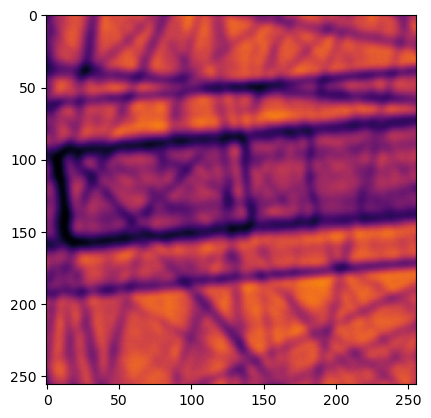

In [5]:
plt.imshow(dp[0], vmax=5e5)

In [4]:
dtpar = [16.868, 4.1797e-5, 1.1108, 1.047, 0.07229]
#dtpar = [1,1,1,1,1]
background = 38
mtf = 1
print(gindex)

[[ 0.  0.  0.]
 [-4.  4.  4.]
 [ 4. -4. -4.]]


In [5]:
dinfo = LARBEDDiffractionInfo(dp,  859.95800882591936,  -3.52, -5.04, 39, 'examples/GGG/ggg_LARBED.dat', dtpar, background,gindex)
#dinfo = LARBEDDiffractionInfo(dp,  859.95800882591936,  0, 0, 39, 'examples/Cu2O/ZSM5.dat', dtpar, background,gindex)
#np.flip(dp[31],axis=1)
#print(dinfo.dp[23])
#print(dinfo.gindex)

# region of interest parameters:
defines the region of interest for refinement
- rotation: relative to the xaxis set in .dat
- nthgx: which hkl relative to the xaxis set in .dat
- dpCenter: of diffraction pattern for simulation as reference point
- dpSize: size of the diffraction pattern for simulation

In [6]:
rotation = 211
nthgx = [0,0,0]
dpCenter = [175, 175]
dpSize = [256,256]
dp_index = 0
sim_index = 0


In [9]:
import importlib
import roi
importlib.reload(roi)
from roi import LARBEDROI

In [7]:
roi = LARBEDROI(dinfo=dinfo, rotation=rotation, gx=np.array([0,0,4]), gInclude=gindex, dpCenter=dpCenter, 
                dpSize=dpSize, dp_index=dp_index, sim_index=sim_index, probe = 7) 
print(sim_index, dp_index)
print(gindex[dp_index])
#print(roi.dinfo.lastParam)


include beam initialized
group symmetry initialized
0 0
[0. 0. 0.]


After you find a LARBED area that matches pull out the hkl and manually inset them into the dat file. This will fix discrepencies with missing beams later

ROI MUST BE SYMMETRIC or the refined position will not align the simulation with the experimental data adjust dpcenter if the roi is clipping

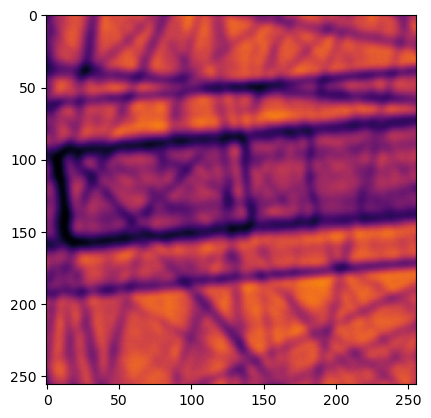

In [8]:
plt.imshow(roi.dp[0], vmax=5e5)

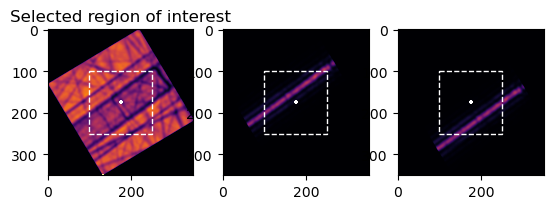

In [9]:
roi.selectROI(np.array([[[-75,-75], [-75, 75], [75,-75], [50,50]]]))
roi.displayROI()



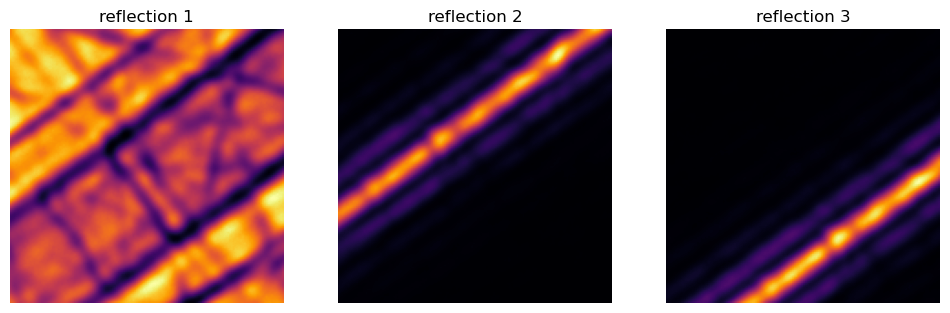

In [10]:
coarse = CoarseOptimize(datpath='examples/GGG/ggg_LARBED.dat', dinfo=dinfo, roi=roi)

In [11]:
coarse.optimizeOrientationThickness()


Optimization terminated successfully;
The returned value satisfies the termination criteria
(using xtol = 0.001 )
include beam initialized
group symmetry initialized
thickness: 797.8477747301989, gl: 39, tiltY: -4.855978859145873, tiltX: -3.5476031711281193


IF THE COARSE SEARCH IS WAY OFF YOU NEED TO FIX TILT, ROTATION, OR ADJUST GL

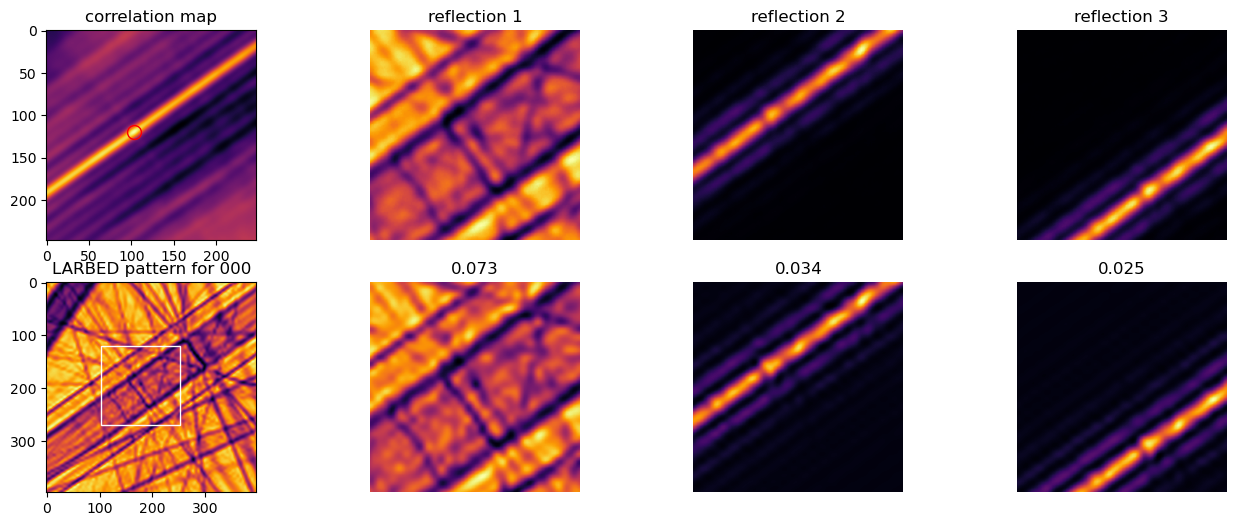

In [12]:
coarse.displayCoarseSearch()

In [13]:
reflection_list = []
reflection_list = [(4,-4,-4),(5,-5,-6)]
print(reflection_list)

[(4, -4, -4), (5, -5, -6)]


Sometimes ROI is flipping when moving from coarse to fine. Im not sure where this bug is. Trying to find it. For now inverting the ROI works

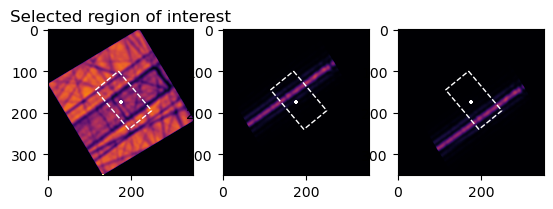

In [14]:
# roi.selectROI(np.array([[[-75,-5], [20, 75], [-30,-60], [62,35]]]))                        ]))
roi.selectROI(np.array([[[-75,-5], [20, 75], [-30,-60], [62,35]]]))
# roi.selectROI(np.array([[[-20,-20], [-20, 140], [140,-20], [40,40]]]))
roi.displayROI()
#roi.calculatePixelSize()

In [18]:
import importlib
import optimize
import gof
importlib.reload(gof)
from gof import Chi2_poisson
# from optimize import FineOptimize

In [15]:
fine = FineOptimize(dinfo=dinfo, roi=roi, reflections=reflection_list, errorFunc=Chi2_poisson(), perturbROI=True, )

In [25]:
dinfo.getSF((4,-4,-4))

array([4.05799635e-02, 1.80000000e+02, 2.99347169e-03, 0.00000000e+00])

797.8477747301989
setting the initial value and normalization range to:
beam: (4, -4, -4)
      lower       value       upper  
U : 0.0385510   0.0405800   0.0426090
UA: 0.0028438   0.0029935   0.0031431
------------------------------
beam: (5, -5, -6)
      lower       value       upper  
U : 0.0063029   0.0066347   0.0069664
UA: 0.0006087   0.0006407   0.0006728
------------------------------
(4, -4, -4): U 0.0405800 UA 0.0029935
(5, -5, -6): U 0.0066347 UA 0.0006407
Chi Square single background no detector: 1604.71088


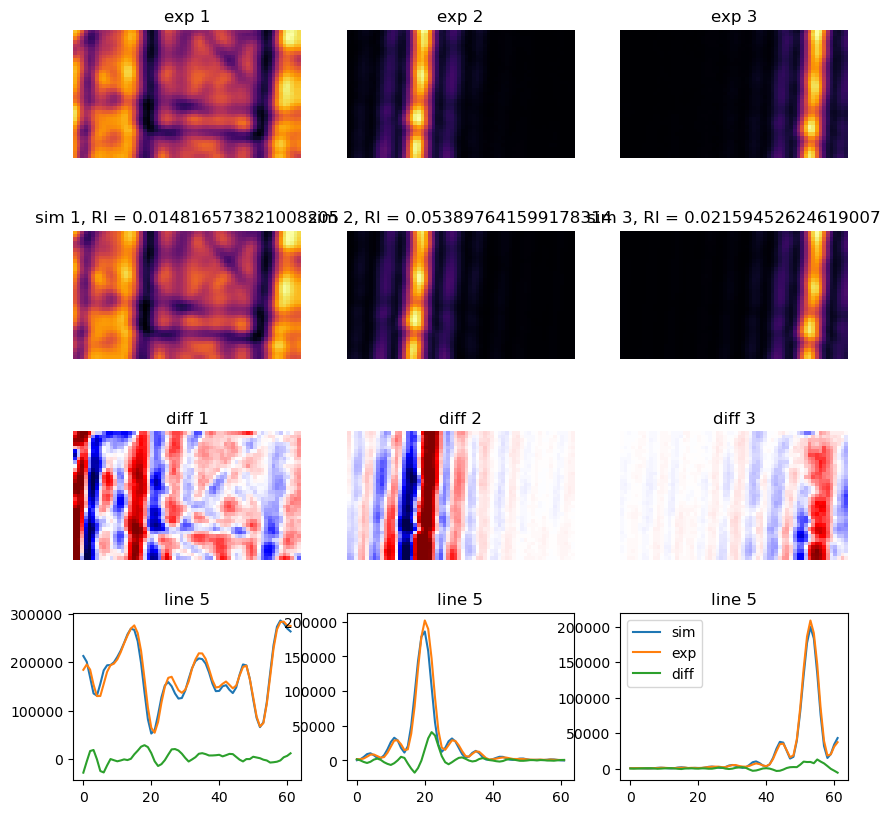

In [16]:
print(fine.thickness)
fine.getx0()
fine.getRange()
# fine.x0 = np.array(opt_array)
fine.display([5,])

In [17]:
%matplotlib qt
#roi.gl = 37.76466
#roi.sigma =roi.sigma*5

fine.optimize()
#fine.optimize(np.array([[1.0, 1.0],[1.0, 1.0],[1.0, 1.0],[1.0, 1.0]]))
# fine.optimize()

setting the initial value and normalization range to:
beam: (4, -4, -4)
      lower       value       upper  
U : 0.0385510   0.0405800   0.0426090
UA: 0.0028438   0.0029935   0.0031431
------------------------------
beam: (5, -5, -6)
      lower       value       upper  
U : 0.0063029   0.0066347   0.0069664
UA: 0.0006087   0.0006407   0.0006728
------------------------------
SF:
 (4, -4, -4): [0.04057996 0.00299347]
 (5, -5, -6): [0.00663468 0.00064074]


libGL error: MESA-LOADER: failed to open swrast: /usr/lib/dri/swrast_dri.so: cannot open shared object file: No such file or directory (search paths /usr/lib/x86_64-linux-gnu/dri:\$${ORIGIN}/dri:/usr/lib/dri, suffix _dri)
libGL error: failed to load driver: swrast


thickness: 789.52 gl: 38.41879 rotation: 210.43941 sigma 1.13106
corner: -0.54073 -0.06111
GOF: 216.26371  func eval: 255
Error: 215.96472734254993  func eval: 255
********************
SF:
 (4, -4, -4): [0.04068141 0.00299347]
 (5, -5, -6): [0.00663468 0.00064074]
thickness: 788.43 gl: 38.41815 rotation: 210.43796 sigma 1.12913
corner: -0.54068 -0.05989
GOF: 222.45405  func eval: 104
Error: 222.1465053763441  func eval: 104
********************
SF:
 (4, -4, -4): [0.04057996 0.00300096]
 (5, -5, -6): [0.00663468 0.00064074]
thickness: 789.53 gl: 38.41980 rotation: 210.43910 sigma 1.13089
corner: -0.54026 -0.06337
GOF: 216.32589  func eval: 96
Error: 216.02682411674348  func eval: 96
********************
SF:
 (4, -4, -4): [0.04057996 0.00299347]
 (5, -5, -6): [0.00665127 0.00064074]
thickness: 789.53 gl: 38.41914 rotation: 210.43902 sigma 1.13104
corner: -0.54029 -0.06330
GOF: 216.30172  func eval: 48
Error: 216.002688172043  func eval: 48
********************
SF:
 (4, -4, -4): [0.040579

(4, -4, -4): U 0.0395565 UA 0.0030000
(5, -5, -6): U 0.0066859 UA 0.0006435
Chi Square single background no detector: 185.74840


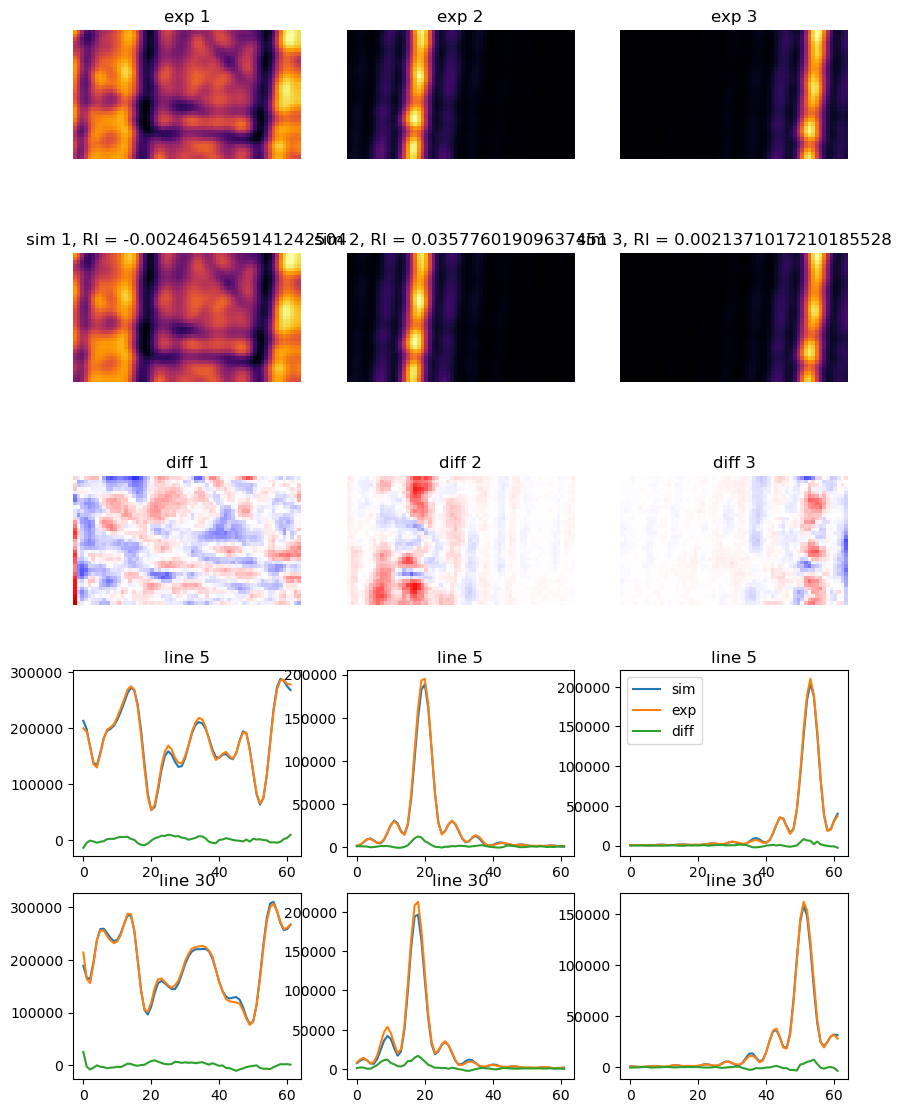

In [18]:
%matplotlib inline
fine.display([5,30])

In [19]:
from callBloch import terminate
terminate()

In [42]:
'''%matplotlib inline
reflection_list = []


print(len(fine.reflections))
for i in range(len(simCBED)):
    if np.max(simCBED[i]) > 0.05:
        plt.figure()
        plt.imshow(simCBED[i].reshape(20,150))
        plt.title(str(roi.dinfo.lastParam.hklout.T[i]) + str(np.max(simCBED[i])))
        reflection_list.append((roi.dinfo.lastParam.hklout.T[i][0],
                        roi.dinfo.lastParam.hklout.T[i][1],
                        roi.dinfo.lastParam.hklout.T[i][2]))
    else:
        continue
reflection_list[1]
reflection_list = np.delete(reflection_list,[1],axis=0)
print(reflection_list)'''

'%matplotlib inline\nreflection_list = []\n\n\nprint(len(fine.reflections))\nfor i in range(len(simCBED)):\n    if np.max(simCBED[i]) > 0.05:\n        plt.figure()\n        plt.imshow(simCBED[i].reshape(20,150))\n        plt.title(str(roi.dinfo.lastParam.hklout.T[i]) + str(np.max(simCBED[i])))\n        reflection_list.append((roi.dinfo.lastParam.hklout.T[i][0],\n                        roi.dinfo.lastParam.hklout.T[i][1],\n                        roi.dinfo.lastParam.hklout.T[i][2]))\n    else:\n        continue\nreflection_list[1]\nreflection_list = np.delete(reflection_list,[1],axis=0)\nprint(reflection_list)'